# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025   | Adrienne | Update | Creating models |
| 05/10/2025 | Adrienne | Update | Created baseline model with KMeans |
| 07.10.2025 | Adrienne | Update | Added code for wordcloud visualization |

# Content

* [Introduction](#introduction)

In [19]:

import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture

# dimensionality reduction methods
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import setuptools
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

## Load Data

In [2]:
# readin in patient level file label encoded
path = "../data/clean"
df_lab_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")
df_patient = pd.read_pickle(f"{path}/patient_level.pkl")

In [4]:
# readin icd10 mapper
mapper_path = "../data/mappers"
icd10_mapper = pd.read_pickle(f"{mapper_path}/icd10.pkl")

## Model Development

We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared

### Baseline Model - KMeans

Todo: 
- find optimal clusters
- examine most important feature by principal component
 - create graph of clusters with principal components
 - optimize any model inputs

In [5]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_lab_enc)

Dimensionality Reduction

In [6]:
# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

In [ ]:
# kmeans code
kmeans = KMeans(init = 'random', n_clusters=12, n_init=10, random_state = 0) 
km = kmeans.fit(X_pca) 
km.n_iter_
labels = km.labels_
#print(labels)


[8 7 0 ... 0 7 8]


In [9]:
# add cluster results to dataset
df_lab_enc['cluster'] = labels

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_8987/1552931060.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_enc['cluster'] = labels


In [ ]:
# quick look at cluster values
vals = df_lab_enc['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

### Finding Optimal Clusters

Silhouette Score

In [ ]:
# works for all sklearn unsupervised model evaluation metrics with DBSCAN
score = silhouette_score(X_pca, km.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.530


Create a Silhouette Plot

0


IndexError: index 2 is out of bounds for axis 0 with size 2

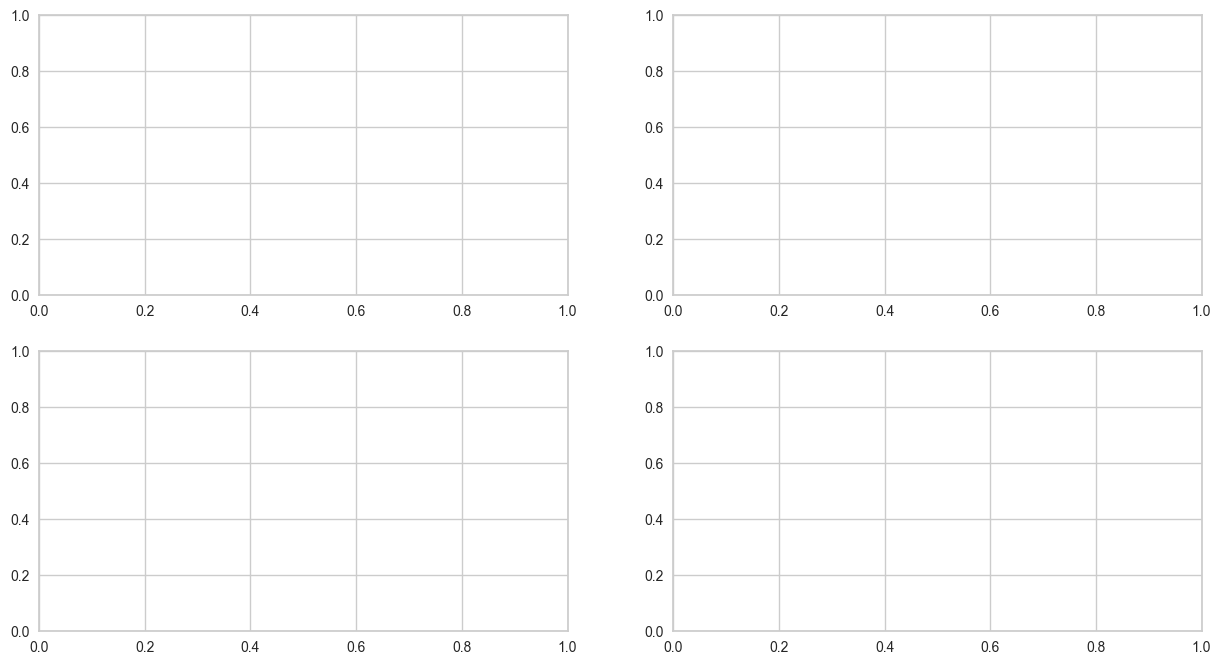

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [6, 7, 8, 9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=50, random_state=42)

    q, mod = divmod(i, 2)
    print(mod)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_pca)  

Elbow Method

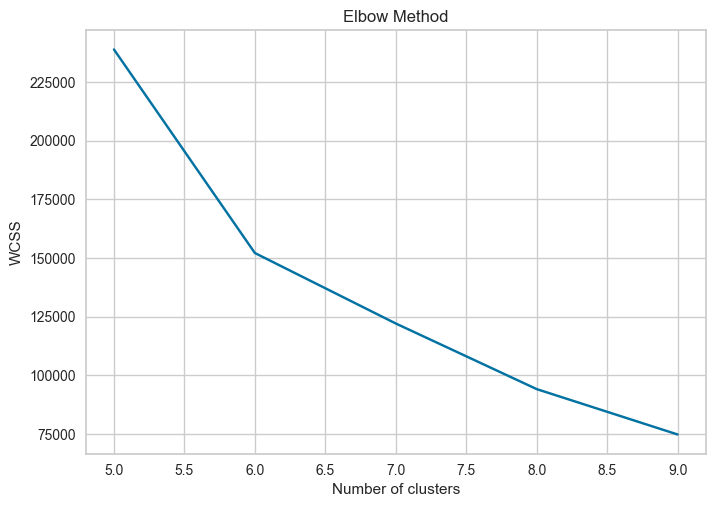

In [30]:
# Finding the optimal number of clusters using Elbow Method
wcss = []
for i in range(5, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(5, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Code for graphing - setting aside for now

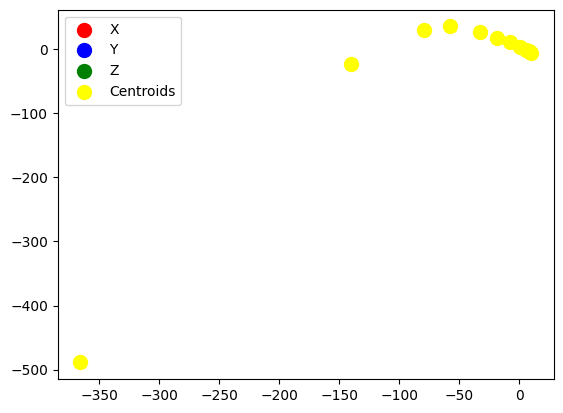

In [12]:
plt.scatter(X_pca['cluster' == 0, 0], X_pca['cluster' == 0, 1], s = 100, c = 'red', label = 'X')
plt.scatter(X_pca['cluster'== 1, 0], X_pca['cluster' == 1, 1], s = 100, c = 'blue', label = 'Y')
plt.scatter(X_pca['cluster'== 2, 0], X_pca['cluster' == 2, 1], s = 100, c = 'green', label = 'Z')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

In [ ]:
components = pca.components_
feature_names = df_lab_enc.columns
feature_contributions = pd.DataFrame(components, columns=feature_names)

print(feature_contributions)


In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()

In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df_lab_enc.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

In [ ]:
principal_df = pd.DataFrame(data= X_pca)

In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(principal_df[0], principal_df[1])
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


In [ ]:
principal_df = pd.DataFrame(data= X_pca, columns = ['principal_comp_1', 'principal_comp_2', 'principal_comp_3', 'principal_comp_4', 'principal_comp_5'])

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("XXX",fontsize=20)
targets = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#targets = [ 0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y', 'r', 'g', 'b', 'y', 'r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = df_lab_enc['cluster'] == target
    print(indicesToKeep)
    plt.scatter(principal_df.loc[indicesToKeep, 'principal_comp_1']
               , principal_df.loc[indicesToKeep, 'principal_comp_2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})


In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.iloc[:, 2], y=df_lab_enc.iloc[:, 3], c= model.labels_)

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.loc[:, 'hcpcs_0_enc'], y=df_lab_enc.loc[:, 'number_of_claims'], c= model.labels_)
# plt.xlabel('Annual Income (k$)')
# plt.ylabel('Spending Score (1-100)')

In [ ]:
# Assign the cluster centers: centroids
centroids = model.cluster_centers_# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()

In [ ]:
for i, cluster in enumerate(clusters):
    plt.scatter(data[:, 0], data[:, 1], c=cluster, label=f'Cluster {i+1}')
plt.scatter(*centroids, c='red', marker='x', s=200, label='Centroids')
plt.legend()
plt.show()


### Hierarchical Clustering

In [ ]:
# works for AgglomerativeClustering, FeatureAgglomerization and DBScan
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
labels = agg_clustering.fit_predict(X_train)


### Guassian Mixture

In [ ]:
# GMM code
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)
labels = gmm.predict(X_train)

Model Evaluation

In [ ]:
# elbow method


# works for all sklearn unsupervised model evaluation metrics with DBSCAN
score = silhouette_score(X_train, labels)

Model Selection

In [ ]:
# example grid search

param_grid = {n_components: [2, 5, 8, 10]} # easily add another parameter to this structure

grid_search = GridSearchCV(
    estimator=KMeans(random_state=42, n_init='auto'),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    n_jobs=-1
)

grid_search.fit(X)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Visualizations:

word cloud 


In [190]:
# merge primary diagnosis column back onto data now that it has been through learning
df_patient_test = df_patient[['patient_medicare_number', 'combined_principal_diagnosis_ls']]

df_patient_test['principal_unq'] = df_patient_test['combined_principal_diagnosis_ls'].apply(lambda x: list(set(x)))

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_23972/538535764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient_test['principal_unq'] = df_patient_test['combined_principal_diagnosis_ls'].apply(lambda x: list(set(x)))


In [232]:
# create work cloud column of diagnosis descriptions

for index, row in df_patient_test.head(10).tail(2).iterrows():
    principal_text_ls = []
    print(row['principal_unq'])
    if len(row['principal_unq']) > 1:
        row_ls = []
        for code in row['principal_unq']:
            print(code)
            if any(icd10_mapper[icd10_mapper['CODE'].str.contains(code)]):
                ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index
                print(ind)
                text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION']
                print(f"text {text}")
            else:
                text = 'NaN'
            row_ls.append(text)
        principal_text_ls.append(row_ls)
        print(principal_text_ls)
    else:
        row_ls = []
        print(code)
        if icd10_mapper[icd10_mapper['CODE'].str.contains(code)].any():
            ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0]
            print(ind)
            text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION']
            print(f"text {text}")
        row_ls.append(text)
    principal_text_ls.append(row_ls)
    print(principal_text_ls)


['M797', 'J0190', 'E785', 'J329']
M797
Index([16811], dtype='int64')
text 16811    Fibromyalgia
Name: SHORT DESCRIPTION, dtype: object
J0190
Index([10541], dtype='int64')
text 10541    Acute sinusitis, unspecified
Name: SHORT DESCRIPTION, dtype: object
E785
Index([4035], dtype='int64')
text 4035    Hyperlipidemia, unspecified
Name: SHORT DESCRIPTION, dtype: object
J329
Index([10647], dtype='int64')
text 10647    Chronic sinusitis, unspecified
Name: SHORT DESCRIPTION, dtype: object
[[16811    Fibromyalgia
Name: SHORT DESCRIPTION, dtype: object, 10541    Acute sinusitis, unspecified
Name: SHORT DESCRIPTION, dtype: object, 4035    Hyperlipidemia, unspecified
Name: SHORT DESCRIPTION, dtype: object, 10647    Chronic sinusitis, unspecified
Name: SHORT DESCRIPTION, dtype: object]]
[[16811    Fibromyalgia
Name: SHORT DESCRIPTION, dtype: object, 10541    Acute sinusitis, unspecified
Name: SHORT DESCRIPTION, dtype: object, 4035    Hyperlipidemia, unspecified
Name: SHORT DESCRIPTION, dtype: objec

In [252]:
# create work cloud column of diagnosis descriptions

for index, row in df_patient_test.iterrows():

    #print(row['principal_unq'])
    if len(row['principal_unq']) > 1:
        row_ls = []
        for code in row['principal_unq']:
            #print(code)
            if icd10_mapper['CODE'].isin([code]).any():
                ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
                #print(ind)
                text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split()[0:2]
                #print(f"text {text}") 
            # else:
            #     text = 'NaN'
            row_ls.append(text)
        row_ls = [i for i in row_ls if i != ['unspecified']]   
        #print(row_ls)
        df_patient_test.at[index, 'word_cloud'] = row_ls

    else:
        #print(code)
        if icd10_mapper['CODE'].str.contains(code).any():
            ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0]
            #print(ind)
            text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split()[0:2]
            #print(f"text {text}")
            df_patient_test.at[index, 'word_cloud'] = text



In [253]:
df_patient_test.head()

,patient_medicare_number,combined_principal_diagnosis_ls,principal_unq,word_cloud
8249,1S00E00GA44,"[E669, E669, J029, J029, J029, J029, J029]","[E669, J029]","[[Obesity,, unspecified], [Acute, pharyngitis,]]"
48386,1S00E00JN08,"[B085, B349, E785, E785, J329, J329, J329, J32...","[J029, J0190, J209, B085, J329, B349, E785]","[[Acute, pharyngitis,], [Acute, sinusitis,], [..."
36869,1S00E00HT71,"[E785, O039, E785, B002, E785, E785, E785, E78...","[S46029, O039, B002, S46019, E785]","[[Hyperlipidemia,, unspecified], [Complete, or..."
84632,1S00E00MW82,"[E669, E669, E669, E669, E669, E669, E669, E66...","[C50929, E669, J0190, B085, C50919, J329, B349...","[[Malignant, neoplasm], [Obesity,, unspecified..."
10413,1S00E00GE68,"[C50929, C50929, C50919, C50919, C50919, C5091...","[C50929, I639, J209, C50919, J329, J0390, J029]","[[Malignant, neoplasm], [Cerebral, infarction,..."


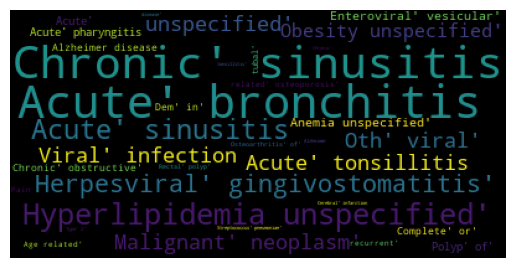

In [259]:
diag_cloud = df_patient_test['word_cloud'].head(100).apply(str).str.cat(sep=', ')
#Instantiate wordcloud object and use method to feed it our corpus
wc = WordCloud().generate_from_text(diag_cloud)

#Use matplotlib.pyplot to display the fitted wordcloud
#Turn axis off to get rid of axis numbers
plt.imshow(wc)
plt.axis('off')
plt.show()